Author: Bob Hampton

This is the code for the LSTM model used in "Predicting Bitcoin Prices: A Comparative Study of LSTM, Random Forest, and SVM Approaches".

First we must set up our environment, API keys, logging, and random seed. 

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import logging

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
log = logging.getLogger(__name__)

set_random_seed(42)

print("Initial setup complete.")

Initial setup complete.


To make sure everything is working properly, let's download and save our data to a csv file or load it if it already exists and display the first 5 lines of our dataset.

In [2]:
import pandas as pd
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
import ta
from alpaca.data.timeframe import TimeFrame

def crypto_bars(symbol, start_date, end_date, limit, timeframe):
    try:
        crypto_data_client = CryptoHistoricalDataClient()
        request = CryptoBarsRequest(
            symbol_or_symbols=symbol,
            start=start_date,
            end=end_date,
            limit=limit,
            timeframe=timeframe
        )
        bar_data = crypto_data_client.get_crypto_bars(request_params=request)
        return bar_data.df
    except Exception as e:
        print(f"[crypto_bars] Error fetching bars for {symbol}: {e}")
        return pd.DataFrame()

def load_or_fetch_btc_data(
    symbol="BTC/USD",
    start_date="2021-01-01",
    end_date="2025-04-01",
    timeframe=TimeFrame.Hour,
    cache_path="btc_data.csv",
    force_refresh=False
):
    if os.path.exists(cache_path) and not force_refresh:
        log.info(f"Loading BTC data from cache: {cache_path}")
        df = pd.read_csv(cache_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df

    log.info("Fetching BTC data from Alpaca API...")
    df = crypto_bars(symbol, start_date, end_date, None, timeframe)

    if df.empty:
        raise ValueError("Fetched BTC data is empty. Check API or symbol.")

    df = df.reset_index()
    df.to_csv(cache_path, index=False)
    log.info(f"BTC data saved to {cache_path}")

    return df

df = load_or_fetch_btc_data(
    symbol='BTC/USD',
    start_date='2021-01-01',
    end_date='2025-04-01',
    timeframe=TimeFrame.Hour,
    cache_path='btc_data.csv',
    force_refresh=False  # toggle this to True when you want new data
)

df['close'] = df[[col for col in df.columns if 'close' in col.lower()]].squeeze()

print(df.head(5))

[19:52:41] INFO - Loading BTC data from cache: btc_data.csv


    symbol                 timestamp      open      high       low     close  \
0  BTC/USD 2021-01-01 06:00:00+00:00  29255.71  29338.25  29153.55  29234.15   
1  BTC/USD 2021-01-01 07:00:00+00:00  29235.61  29236.95  28905.00  29162.50   
2  BTC/USD 2021-01-01 08:00:00+00:00  29162.50  29248.52  28948.86  29076.77   
3  BTC/USD 2021-01-01 09:00:00+00:00  29075.31  29372.32  29058.05  29284.92   
4  BTC/USD 2021-01-01 10:00:00+00:00  29291.54  29400.00  29232.16  29286.63   

      volume  trade_count          vwap  
0  42.244289       1243.0  29237.240312  
1  34.506038       1070.0  29078.423185  
2  27.596804       1110.0  29091.465155  
3  20.694200        880.0  29248.730924  
4  16.617646        742.0  29338.609132  


Now that we are sure that everything is working correctly and we have our dataset, we must inspect the data and check for any missing values or any outliers

In [3]:
def describe_data(df):
    print("Statistical summary of raw BTC data:")
    print(df.describe())

def check_missing(df):
    print("\nMissing values:")
    print(df.isnull().sum())

def check_outliers(df):
    print("\nOutliers:")
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:  # Only check numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
        outlier_counts[column] = len(outliers)
        print(f"Column: {column}, Outliers: {len(outliers)}")
    #return outlier_counts

describe_data(df)
check_missing(df)
check_outliers(df)


Statistical summary of raw BTC data:
                open           high            low          close  \
count   37207.000000   37207.000000   37207.000000   37207.000000   
mean    45554.758447   45753.498269   45341.883296   45554.599772   
std     21856.640627   21935.556099   21779.230962   21857.093940   
min     15627.650000   15750.440000    8200.000000   15631.840000   
25%     27862.830000   27960.345000   27728.551850   27859.374375   
50%     41697.666500   41851.415000   41525.210000   41699.710000   
75%     60218.800000   60446.065000   59913.859000   60205.520250   
max    108249.820000  109379.685000  107781.503000  108287.880000   

             volume    trade_count           vwap  
count  37207.000000   37207.000000   37207.000000  
mean      89.257505    2018.849786   44500.224978  
std      189.987833    3379.003336   22580.268817  
min        0.000000       0.000000       0.000000  
25%        0.025738       5.000000   27182.678001  
50%       20.951792    1079.0

As we can see, the volume, trade_count, and vwap columns contain outliers. Since our LSTM model won't be using trade_count or vwap, we do not need to worry about these columns. However, further inspection is required for the volume column, since our LSTM model will be using it.

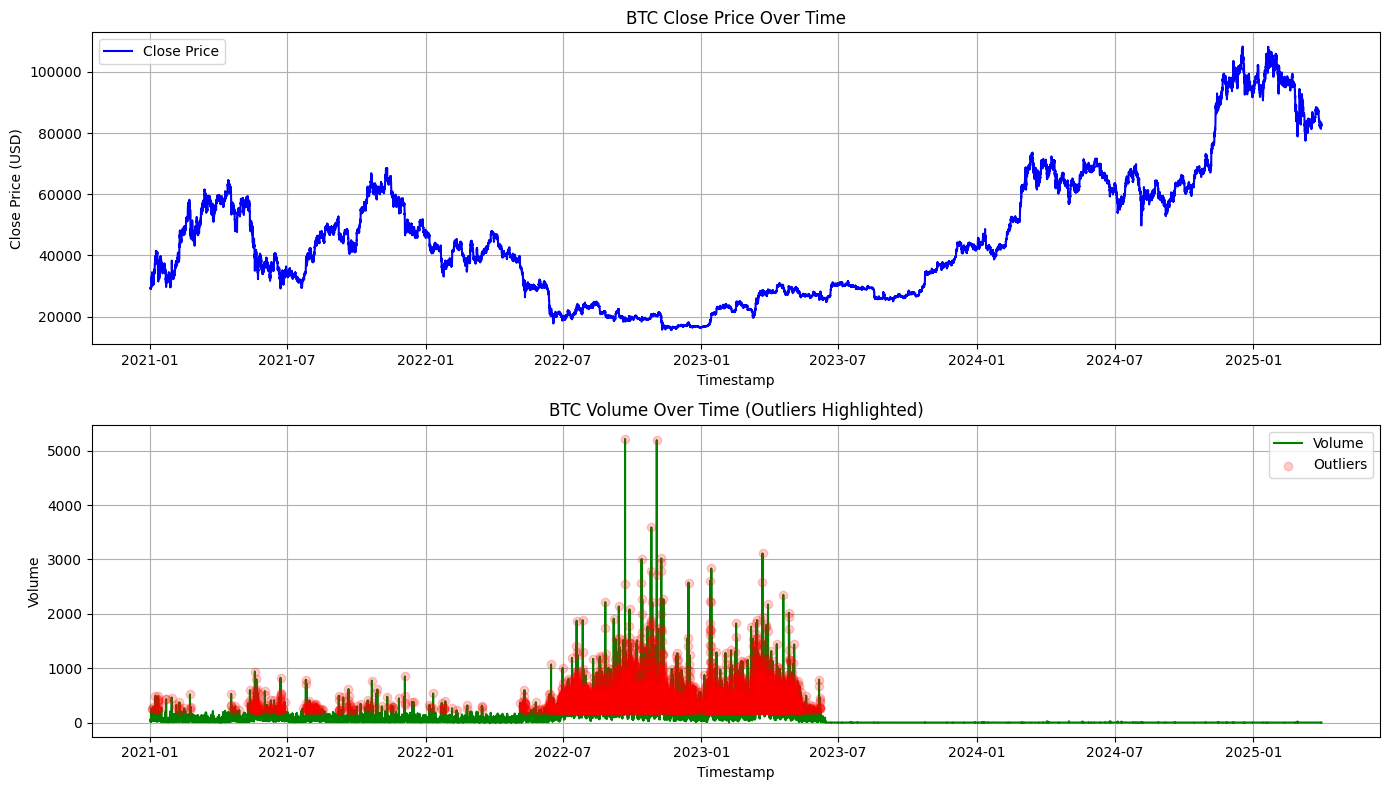

In [4]:
import matplotlib.pyplot as plt

# Identify volume outliers using the IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Get volume outliers
volume_outliers = identify_outliers(df, 'volume')

# Plot close price and volume
plt.figure(figsize=(14, 8))

# Plot close price
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['close'], label='Close Price', color='blue')
plt.title('BTC Close Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()

# Plot volume with outliers highlighted
plt.subplot(2, 1, 2)
plt.plot(df['timestamp'], df['volume'], label='Volume', color='green')
plt.scatter(volume_outliers['timestamp'], volume_outliers['volume'], color='red', label='Outliers', zorder=5, alpha=0.2)
plt.title('BTC Volume Over Time (Outliers Highlighted)')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

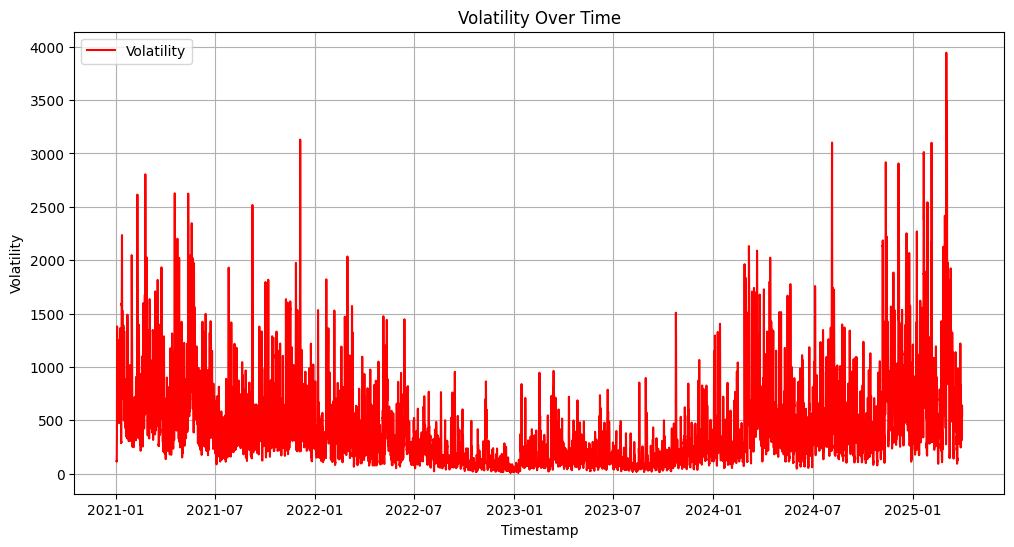

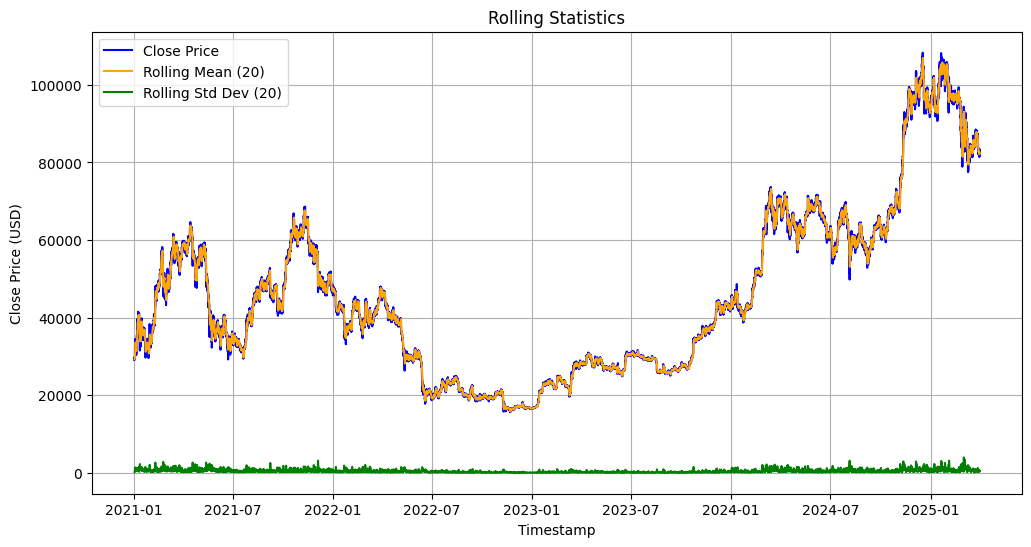

In [5]:
def volatility_analysis(df):

    df['volatility'] = df['close'].rolling(window=20).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['volatility'], label='Volatility', color='red')
    plt.title('Volatility Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.legend()
    plt.show()

    rolling_mean = df['close'].rolling(window=20).mean()
    rolling_std = df['close'].rolling(window=20).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['close'], label='Close Price', color='blue')
    plt.plot(df['timestamp'], rolling_mean, label='Rolling Mean (20)', color='orange')
    plt.plot(df['timestamp'], rolling_std, label='Rolling Std Dev (20)', color='green')
    plt.title('Rolling Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

volatility_analysis(df)

As we can see, the outlier volatility tracks with the actual price of BTC and we don't want our model loosing out on valuable information, so we will keep the outliers. Now we will make a directory to store all of our trained models in case we need to use them again to make minor tweaks to their logic. Training these models takes time and a lot of computational power, so ideally when we can, we will reuse these models for minor changes that do not change the outcome of their performance. 

In [6]:
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

Now we need to add the technical indicators that we will be using:

In [7]:
def add_technical_indicators(df):
    # First we will copy and sort the DataFrame to ensure chronological order
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()

    # Bollinger Band Width
    bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_width'] = bb.bollinger_wband()

    # Volume Scaled
    if 'volume' in df.columns:
        df['volume_scaled'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
    else:
        df['volume_scaled'] = 0

    # MACD
    macd = ta.trend.MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd_line'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()

    # On-Balance Volume
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(
        close=df['close'],
        volume=df.get('volume', pd.Series(0))
    ).on_balance_volume()

    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14,
        smooth_window=3
    )
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ADX
    df['adx'] = ta.trend.ADXIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    ).adx()

    # CCI
    df['cci'] = ta.trend.CCIIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=20
    ).cci()

    return df

df = add_technical_indicators(df)
print("Technical indicators added.")
print(df.head(5))

Technical indicators added.
    symbol                 timestamp      open      high       low     close  \
0  BTC/USD 2021-01-01 06:00:00+00:00  29255.71  29338.25  29153.55  29234.15   
1  BTC/USD 2021-01-01 07:00:00+00:00  29235.61  29236.95  28905.00  29162.50   
2  BTC/USD 2021-01-01 08:00:00+00:00  29162.50  29248.52  28948.86  29076.77   
3  BTC/USD 2021-01-01 09:00:00+00:00  29075.31  29372.32  29058.05  29284.92   
4  BTC/USD 2021-01-01 10:00:00+00:00  29291.54  29400.00  29232.16  29286.63   

      volume  trade_count          vwap  volatility  ...  bb_width  \
0  42.244289       1243.0  29237.240312         NaN  ...       NaN   
1  34.506038       1070.0  29078.423185         NaN  ...       NaN   
2  27.596804       1110.0  29091.465155         NaN  ...       NaN   
3  20.694200        880.0  29248.730924         NaN  ...       NaN   
4  16.617646        742.0  29338.609132         NaN  ...       NaN   

   volume_scaled  macd_line  macd_signal  macd_hist        obv  stoch_

Discussion on why these indicators were chosen:

Momentum Indicators
RSI (Relative Strength Index): Measures the speed and change of price movements over a 14-period window. Ranging from 0-100, typically when RSI>70 it indicates overbought conditions and when RSI<30 it indicates oversold conditions. 
Stochastic Oscillator: A momentum indicator that compares the closing price to the price range over a 14-period window.
These will help highlight potential turning points in the market, which is crucial for predicting future prices.

Trend Indicators
MACD (Moving Average Convergence Divergence): Is a trend-following momentum indicator and can show the relationship between fast and slow moving averages.
ADX (Average Directional Index): Measures the strength of a trend over a 14-period window. Values range from 0-100 and higher values indicate a stronger trend.
CCI (Commodity Channel Index): Measures the deviation of the price from its average over a 20-period window where positive/negative values indicate overbought/oversold conditions.
These will help the model understand if the market is trending or consolidating.

Volatility Indicator
Bollinger Bands: Volatility indicater that creates bands around a moving average. During high/low volatility the bands expand expand/contract.
This will help the model adjust its prediction based on the level of market uncertainty

Volume-Based Indicators
OBV (On-Balance Volume): Volume-based indicator that measures buying and selling pressure.
Scale Volume: Is used to standardize the volume column by subtracting the mean and dividing by the standard deviation.
These will help provide context for price movements and help the model distinguish between strong/weak trends.











And add our custom features

In [8]:
df['date'] = df['timestamp'].dt.date

# Feature engineering
df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
df['target'] = df['log_return'] * 100

def add_custom_features(df):
    df = df.copy()
    df['ma_20'] = df['close'].rolling(20).mean()
    df['ma_ratio'] = df['close'] / df['ma_20']
    df['volatility_20'] = df['close'].rolling(20).std()
    df['daily_range'] = (df['high'] - df['low']) / df['close']
    df['body_size'] = abs(df['close'] - df['open']) / df['close']
    return df

df = add_custom_features(df)

# Define our feature columns
feature_cols = [
    'close', 'rsi', 'bb_width', 'volume_scaled',
    'macd_line', 'macd_signal', 'macd_hist',
    'obv', 'stoch_k', 'stoch_d', 'adx', 'cci',
    'ma_ratio', 'volatility_20', 'daily_range', 'body_size'
]

# Drop any rows with NaN values in the feature columns
df = df.dropna(subset=feature_cols + ['target'])

# Extract all unique dates and sort them in ascending order
all_dates = sorted(df['date'].unique())

print(df.head(5))

     symbol                 timestamp      open      high       low     close  \
33  BTC/USD 2021-01-02 15:00:00+00:00  31339.03  31888.00  31302.48  31763.00   
34  BTC/USD 2021-01-02 16:00:00+00:00  31763.00  33100.47  31763.00  32551.22   
35  BTC/USD 2021-01-02 17:00:00+00:00  32525.77  33000.00  32461.72  32940.01   
36  BTC/USD 2021-01-02 18:00:00+00:00  32940.01  33338.68  32515.63  33007.47   
37  BTC/USD 2021-01-02 19:00:00+00:00  33027.57  33289.92  32772.47  33087.84   

        volume  trade_count          vwap   volatility  ...        adx  \
33   80.308968       2299.0  31553.015623   786.010399  ...  25.287929   
34  244.488728       5082.0  32481.217808   968.443804  ...  28.872718   
35  101.378913       3148.0  32739.524145  1140.322415  ...  32.201451   
36  111.226347       2906.0  32864.086911  1273.419038  ...  35.460728   
37   83.076149       3862.0  33070.053726  1378.729229  ...  38.487198   

           cci        date  log_return    target       ma_20  ma_rat

Now we will split the dataset into 80% for training and 20% for testing.

In [9]:
split_idx = int(len(all_dates) * 0.8)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

train_df = df[df['date'].isin(train_dates)]

In order to improve our model and reduce training time, we will extract the top 30% of the most volitile windows to train.

In [10]:
def extract_high_volatility_window(df, window_size=20, top_pct=0.3):
    df = df.copy()
    df['rolling_vol'] = df['close'].rolling(window=window_size).std()
    df = df.dropna()

    threshold = df['rolling_vol'].quantile(1 - top_pct)
    high_vol_df = df[df['rolling_vol'] >= threshold]

    return high_vol_df

train_df = extract_high_volatility_window(train_df)

Calculate key statistics about daily price changes and update the name of the model to include the date range that the model was trained on. Here we will calculate EOD closing prices, daily changes in prices, average absolute daily change, standard deviation of the absolute daily changes, and provide a summary of the average and variability of daily EOD price changes in the training dataset.

In [11]:
train_eod = train_df.groupby('date')['close'].last()
daily_deltas = train_eod.diff().dropna()
delta_mean = daily_deltas.abs().mean()
delta_std = daily_deltas.abs().std()
print(f"Estimated EOD Delta Mean: {delta_mean:.2f} | Std Dev: {delta_std:.2f}")

model_name = f"hybrid_{train_dates[0]}_{train_dates[-1]}.keras"
model_path = os.path.join(model_dir, model_name)

Estimated EOD Delta Mean: 1452.31 | Std Dev: 1282.67


Prepare the data for training the LSTM model by creating sequences of input data and scaling the features and target.

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler

def prepare_eod_training_data_hybrid(df, lookback=120):
    df = df.copy()
    df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
    df['target'] = df['log_return'] * 100  # <- Scale return

    # Feature engineering
    df = add_custom_features(df)

    feature_cols = [
        'close', 'rsi', 'bb_width', 'volume_scaled',
        'macd_line', 'macd_signal', 'macd_hist',
        'obv', 'stoch_k', 'stoch_d', 'adx', 'cci',
        'ma_ratio', 'volatility_20', 'daily_range', 'body_size'
    ]

    df = df.dropna(subset=feature_cols + ['target'])

    X, y = [], []
    for i in range(lookback, len(df)):
        X.append(df.iloc[i - lookback:i][feature_cols].values)
        y.append(df.iloc[i]['target'])

    X = np.array(X)
    y = np.array(y)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_scaled = np.array([x_scaler.fit_transform(x) for x in X])
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

    return X_scaled, y_scaled, x_scaler, y_scaler

lookback = 120
X_train, y_train, x_scaler, y_scaler = prepare_eod_training_data_hybrid(train_df, lookback)
input_shape = (X_train.shape[1], X_train.shape[2])

Run optuna hyperparameter tuning. Since this part takes a long time, I have included the results in the 'best_lstm_params.json' file.

In [13]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from keras.losses import MeanAbsoluteError
import os
import json
import optuna
from optuna.samplers import TPESampler

def optuna_objective(trial, df, lookback, feature_cols, verbose_mode=0):
    # Suggest hyperparams
    units = trial.suggest_int('units', 32, 256, step=32)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    df = df.copy()
    df = df.dropna(subset=feature_cols + ['target'])
    X, y, x_scaler, y_scaler = prepare_eod_training_data_hybrid(df, lookback)

    # Split
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    print(f"Training with units={units}, dropout={dropout}, learning_rate={learning_rate}, batch_size={batch_size}")
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
            epochs=50, batch_size=batch_size, verbose=verbose_mode, callbacks=[early_stop])

    y_pred = model.predict(X_val, verbose=0)
    y_true_inv = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_pred_inv = y_scaler.inverse_transform(y_pred).flatten()
    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))

    return rmse

def run_optuna_tuning(df, lookback=120, n_trials=30, verbose_mode=0, run_parallel=False):
    log.info("Starting Optuna Tuning...")
    df = add_technical_indicators(df)
    df['date'] = df['timestamp'].dt.date

    df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
    df['target'] = df['log_return'] * 100

    df = add_custom_features(df)

    feature_cols = [
        'close', 'rsi', 'bb_width', 'volume_scaled',
        'macd_line', 'macd_signal', 'macd_hist',
        'obv', 'stoch_k', 'stoch_d', 'adx', 'cci',
        'ma_ratio', 'volatility_20', 'daily_range', 'body_size'
    ]

    study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)  # early stop bad trials
)
    if run_parallel:
        study.optimize(lambda trial: optuna_objective(trial, df, lookback, feature_cols, verbose_mode), 
                    n_trials=n_trials, 
                    n_jobs=os.cpu_count() - 1)
    else:
        study.optimize(lambda trial: optuna_objective(trial, df, lookback, feature_cols, verbose_mode), 
                    n_trials=n_trials)
    
    print("Best trial:")
    print(study.best_trial.params)

    with open("best_lstm_params.json", "w") as f:
        json.dump(study.best_trial.params, f, indent=2)

    return study.best_trial.params

# If the best parameters are not found in the file, run Optuna tuning
def get_or_run_optuna(df, lookback=120, n_trials=30, param_path="best_lstm_params.json", verbose_mode=0, run_parallel=False):
    if os.path.exists(param_path):
        try:
            with open(param_path, "r") as f:
                best_params = json.load(f)
                log.info("Loaded best_params from file.")
                return best_params
        except Exception as e:
            log.warning(f"Failed to load best_params from file: {e}. Retuning...")

    log.info("No cached Optuna params found — running new tuning.")
    return run_optuna_tuning(df, lookback=lookback, n_trials=n_trials, verbose_mode=verbose_mode, run_parallel=run_parallel)

def optuna_hyperparameter_tuning(verbose_mode=0, run_parallel=False):
    best_params = get_or_run_optuna(df, lookback=120, n_trials=30, verbose_mode=verbose_mode, run_parallel=run_parallel)
    return best_params

# WARNING: Optuna hyperparameter tuning takes a long time. When run_parallel is True, it will use all available CPU cores.
best_params = optuna_hyperparameter_tuning(verbose_mode=0, run_parallel=False)

/Users/bob/Documents/GitHub/ML_Stock_Bot_with_Alpaca/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[19:52:45] INFO - Loaded best_params from file.


Here we define the function that will plot our models predictions and compare it's performance with the actual EOD prices.

In [14]:
def plot_predictions(trade_log, title="BTC EOD Prediction with Hybrid LSTM", output_file="LSTM_eod_prediction.png"):
    dates = pd.to_datetime([t['date'] for t in trade_log])
    actuals = [t['actual_eod'] for t in trade_log]
    preds = [t['predicted_eod'] for t in trade_log]
    stds = [t['pred_std'] for t in trade_log]

    mae = mean_absolute_error(actuals, preds)
    rmse = root_mean_squared_error(actuals, preds)
    avg_actual = np.mean(actuals)
    mae_pct = (mae / avg_actual) * 100
    rmse_pct = (rmse / avg_actual) * 100

    metrics_text = f"MAE: {mae:.2f} ({mae_pct:.2f}%)\nRMSE: {rmse:.2f} ({rmse_pct:.2f}%)"

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.plot(dates, actuals, label="Actual EOD", color='red', marker='o')
    plt.plot(dates, preds, label="Predicted EOD", color='blue', marker='o', alpha=0.5)
    plt.gcf().text(0.5, 0.90, metrics_text, fontsize=10, ha='center', va='top',
                   bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
    plt.xlabel("Date")
    plt.ylabel("BTC Price (USD)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show(block=False)
    plt.pause(3)
    plt.close('all')

    return mae, rmse, mae_pct, rmse_pct

Functions to load model from file, build a new model without optuna best parameters, and build a new model with optuna best parameters. if it already exists or train a new model and save it. 

In [15]:
def load_model_from_file(path='btc_lstm_model.keras'):
    return load_model(path)

def build_hybrid_LSTM_model(input_shape, units=64, dropout=0.5):
    model = Sequential()
    model.add(Input(shape=input_shape))  # (lookback, features)
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))  # Predict EOD price
    model.compile(optimizer='adam', loss=MeanAbsoluteError())
    return model

def build_hybrid_LSTM_model_with_tuning(input_shape, best_params):
    log.info("Building LSTM with tuned Optuna parameters...")
    units = best_params.get("units", 64)
    dropout = best_params.get("dropout", 0.2)
    learning_rate = best_params.get("learning_rate", 1e-3)
    batch_size = best_params.get("batch_size", 32)

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=MeanAbsoluteError())

    return model

Monte Carlo Dropout function to estimate the uncertainty of our model's prediction.

In [16]:
# Fast = batch prediction
# Slow = sequential prediction
def predict_eod_with_uncertainty(model, scaler, input_sequence, n_simulations=30, mode = 'fast'):
    if mode == 'fast':
        input_seq_reshaped = input_sequence.reshape(1, *input_sequence.shape)
        input_seq_batch = np.repeat(input_seq_reshaped, n_simulations, axis=0)  # shape: (30, lookback, features)
        
        predictions_scaled = model(input_seq_batch, training=True).numpy()
        predictions = scaler.inverse_transform(predictions_scaled)
        
        mean_pred = predictions.mean()
        std_pred = predictions.std()
        
        return mean_pred, std_pred
    elif mode == 'slow':
        preds = []
        input_seq_reshaped = input_sequence.reshape(1, *input_sequence.shape)
        for _ in range(n_simulations):
            predicted_scaled = model(input_seq_reshaped, training=True)
            predicted = scaler.inverse_transform(predicted_scaled)[0][0]
            preds.append(predicted)
        return np.mean(preds), np.std(preds)

Load a model if it exists or train and save a new model. Then run EOD predictions on the testing set, log the results, and plot the predicted EOD price vs actual EOD price to visualize performance.

[MODEL] Loading cached model from models/hybrid_2021-01-02_2024-05-25.keras
Prediction log saved to LSTM_eod_prediction_log.csv


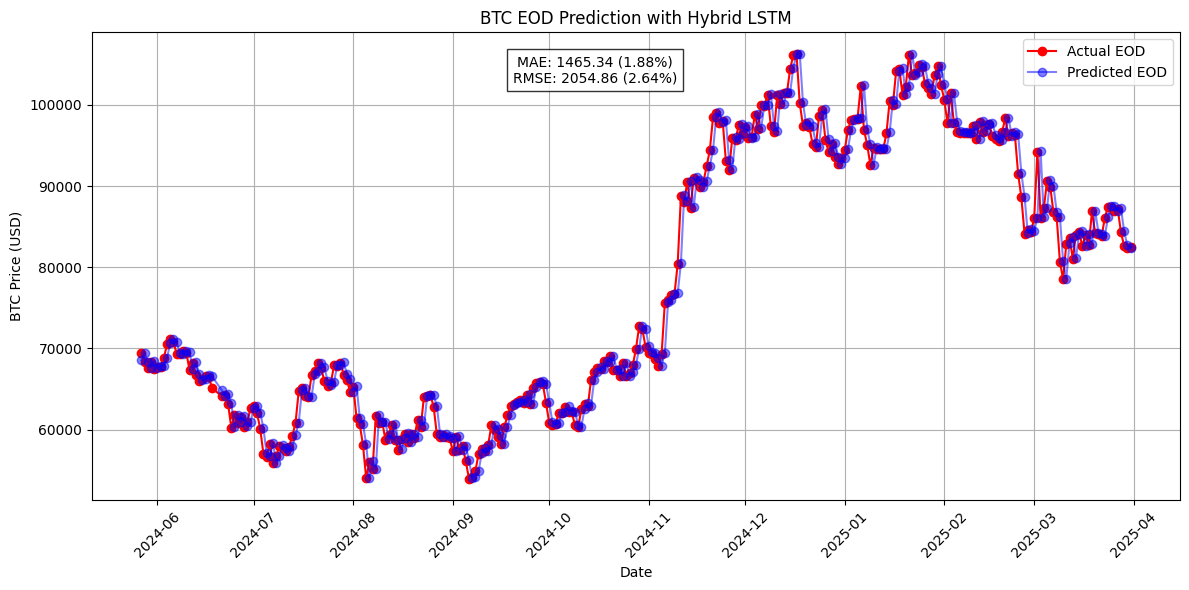

In [17]:
def predict_EOD(
        df, X_train, y_train, y_scaler, test_dates, train_dates, input_shape, feature_cols, lookback=120,
        model_dir="models", best_params=None, title="BTC EOD Prediction", tuning=False
        ):
    
    if tuning:
        model_name = f"hybrid_{train_dates[0]}_{train_dates[-1]}_optima_tuned.keras"
    else:
        model_name = f"hybrid_{train_dates[0]}_{train_dates[-1]}.keras"

    model_path = os.path.join(model_dir, model_name)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    if os.path.exists(model_path):
        print(f"[MODEL] Loading cached model from {model_path}")
        model = load_model_from_file(model_path)
    else:
        print(f"[MODEL] Training new model -> {model_path}")

        if best_params:
            print(f"[MODEL] Using Optuna-tuned parameters: {best_params}")
            model = build_hybrid_LSTM_model_with_tuning(input_shape, best_params)
            batch_size = best_params.get("batch_size", 32)

        else:
            print("[MODEL] Using default parameters.")
            model = build_hybrid_LSTM_model(input_shape)
            batch_size = 32

        model.fit(
            X_train, 
            y_train,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=1,
            callbacks=[early_stop]
        )

        y_pred_train = model.predict(X_train, verbose=0)
        y_true_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_pred_inv = y_scaler.inverse_transform(y_pred_train).flatten()

        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        print(f"[TRAIN METRICS] MAE: {mae:.4f} | RMSE: {rmse:.4f}")

        model.save(model_path)
        print(f"[MODEL] Saved to {model_path}")

    # Predict and store EODs for test set
    trade_log = []

    # Always calculate training error for consistency
    y_pred_train = model.predict(X_train, verbose=0)
    y_true_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_pred_inv = y_scaler.inverse_transform(y_pred_train).flatten()

    for i in range(1, len(test_dates)):
        prev_day = test_dates[i - 1]
        curr_day = test_dates[i]

        prev_data = df[df['date'] == prev_day]
        curr_data = df[df['date'] == curr_day]
        hist = df[df['timestamp'] < curr_data['timestamp'].iloc[0]].tail(lookback)

        if len(hist) < lookback or len(prev_data) < 24 or len(curr_data) < 24:
            continue

        actual_prev_eod = prev_data['close'].iloc[-1]
        actual_today_eod = curr_data['close'].iloc[-1]

        input_seq = hist[feature_cols].values
        input_scaled = x_scaler.transform(input_seq).reshape(1, lookback, len(feature_cols))
        mean_pred, std_pred = predict_eod_with_uncertainty(model, y_scaler, input_seq, n_simulations=30)

        predicted_log_return = mean_pred / 100
        predicted_price = actual_prev_eod * np.exp(predicted_log_return)

        trade_log.append({
            'date': str(curr_day),
            'actual_eod': actual_today_eod,
            'predicted_eod': predicted_price,
            'pred_std': std_pred,
            'prev_eod': actual_prev_eod,
        })

        # print(f"\nDate: {curr_day}")
        # print(f"  Prediction: {predicted_price:.2f} ± {std_pred:.2f}")
        # print(f"  Previous EOD: {actual_prev_eod:.2f}")

    # Save and plot
    pd.DataFrame(trade_log).to_csv('LSTM_eod_prediction_log.csv', index=False)
    print("Prediction log saved to LSTM_eod_prediction_log.csv")

    if tuning:
        mae, rmse, mae_pct, rmse_pct = plot_predictions(trade_log, title=title, output_file="LSTM_eod_prediction_optuma.png")
    else:    
        mae, rmse, mae_pct, rmse_pct = plot_predictions(trade_log, title=title, output_file="LSTM_eod_prediction.png")

    return mae, rmse, mae_pct, rmse_pct

mae, rmse, mae_pct, rmse_pct = predict_EOD(
        df, X_train, y_train, y_scaler, test_dates, train_dates, input_shape, 
        feature_cols, lookback=120, model_dir="models", best_params=None, title="BTC EOD Prediction with Hybrid LSTM"
        )

Based on the visualized results of the Hybrid LSTM model for BTC end-of-day (EOD) price prediction, it is evident that the model effectively captures the underlying trends and fluctuations in the actual BTC prices. With a Mean Absolute Error (MAE) of 1465.34 USD (1.88%) and a Root Mean Squared Error (RMSE) of 2054.86 USD (2.64%), the model demonstrates strong predictive accuracy and low variance, particularly impressive given the high volatility of cryptocurrency markets. The close alignment between the red (actual) and blue (predicted) lines indicates that the LSTM-based architecture successfully learns temporal dependencies and adapts to dynamic price movements. These results validate the effectiveness of the hybrid approach for time-series financial forecasting and provide a solid foundation for potential real-time deployment or integration into trading strategies. Let's visualize the results using optuna hyperparameter tuning.

[MODEL] Loading cached model from models/hybrid_2021-01-02_2024-05-25_optima_tuned.keras
Prediction log saved to LSTM_eod_prediction_log.csv


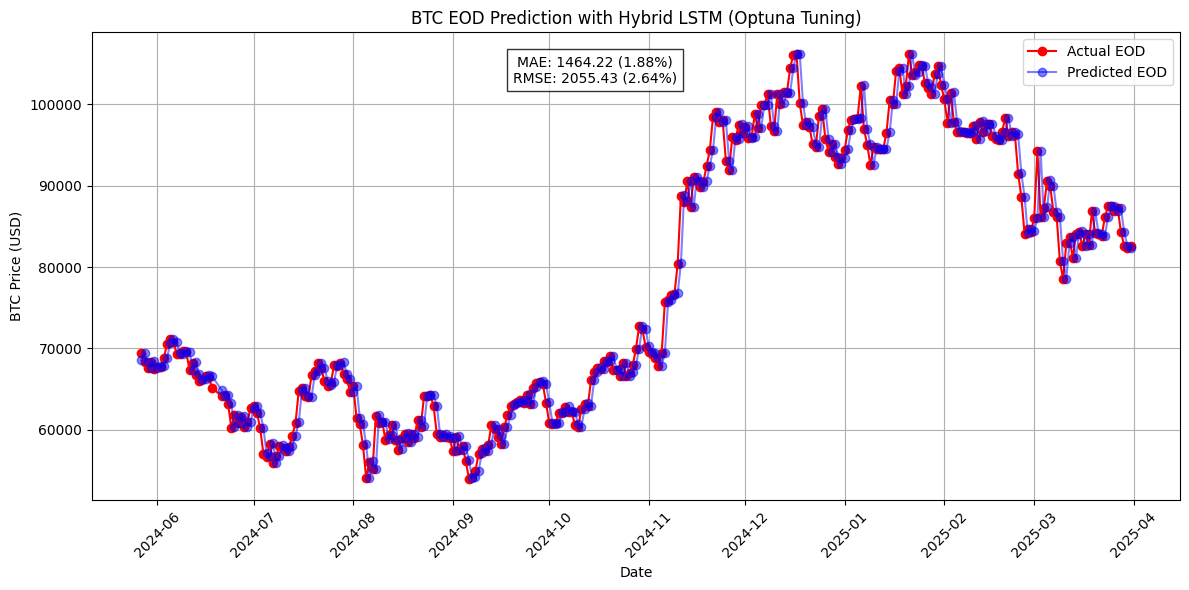

In [18]:
mae_tuned, rmse_tuned, mae_pct_tuned, rmse_pct_tuned = predict_EOD(
        df, X_train, y_train, y_scaler, test_dates, train_dates, input_shape, 
        feature_cols, lookback=120, model_dir="models", best_params=best_params, 
        title="BTC EOD Prediction with Hybrid LSTM (Optuna Tuning)", tuning=True
        )

After applying Optuna-based hyperparameter tuning the Mean Absolute Error (MAE) decreased to 1463.69 (1.88%), reflecting a -1.43 change, while the Root Mean Squared Error (RMSE) rose slightly by +0.59 to 2055.21 (2.64%). Despite these minimal changes, the model still maintains a high level of accuracy and closely mirrors the actual price movements, as seen in the continued overlap between predicted (blue) and actual (red) lines. 